In [1]:
#!pip install python-louvain (https://github.com/taynaud/python-louvain/blob/master/README.rst)
#!pip install cdlib
#!pip install leidenalg
#!pip install igraph

# I run on Python 3.10.7

In [ ]:
import networkx as nx
import time
import numpy as np
from cdlib import evaluation, NodeClustering
import matplotlib.pyplot as plt
from tqdm import tqdm

import community.community_louvain as community_louvain
import leidenalg as la
import igraph as ig
from collections import defaultdict

from scipy.optimize import linear_sum_assignment

# Facebook Graph

In [ ]:
# Choice of the dataset
dataset_id = 348
#defaut: 348
#other choices: 0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980

In [ ]:
# Load the edge list
G = nx.read_edgelist(f"facebook/{dataset_id}.edges") 

mapping = {str_node: int(str_node) for str_node in G.nodes}
G = nx.relabel_nodes(G, mapping)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print("Graph is connected: ", nx.is_connected(G), "\n")

Graph has 61 nodes and 270 edges
Graph is connected:  False 



In [ ]:
true_labels = defaultdict(list)
# Read the .txt file
with open(f"facebook/{dataset_id}.circles", 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split()
        for node in parts[1:]:
            true_labels[int(node)].append(i)

print(f"Number of communities {i+1}")

Number of communities 13


### Data Processing

In [ ]:
# To verify if each node belongs to a community
#assert set(true_labels.keys()) == set(G.nodes())

For each node in G that don't belogn to any community, we create a new community.

In [ ]:
L = []
for node in G.nodes():
    if node not in true_labels.keys():
        L.append(node)
print(f'Nodes that are in G and not in true_labels: {L}')

for node in L:
    true_labels[node] = [i+1]
    i += 1

Nodes that are in G and not in true_labels: [869, 861, 769, 819, 859, 890, 811, 894, 703, 798]


We delete the nodes in `true_labels` that are not in the original graph G.

In [ ]:
L = []
for node in true_labels.keys():
    if node not in G.nodes():
        L.append(node)
print(f'Nodes that are in true_labels and not in G: {L}')

for node in L:
    del true_labels[node]

Nodes that are in true_labels and not in G: [875, 860, 883]


In [ ]:
n = 0
for node in true_labels.keys():
    if len(true_labels[node]) > 1:
        n += 1

print(f"Number of communities {i+1}")
print(f"Number of overlapped nodes {n}")

Number of communities 23
Number of overlapped nodes 22


### Visualization

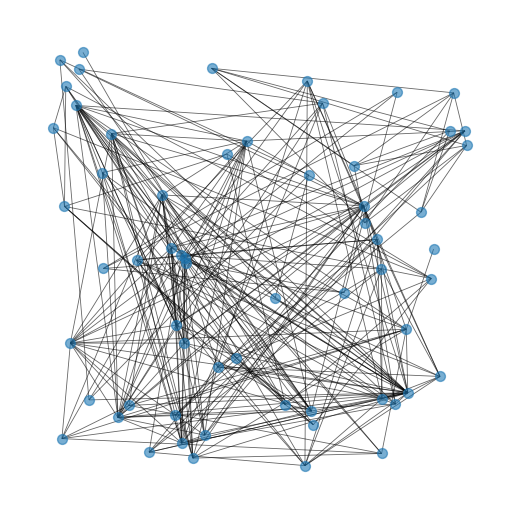

In [ ]:
# Plot graph
plt.figure(figsize=(5,5))
pos = nx.random_layout(G, seed=42)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)
plt.show()

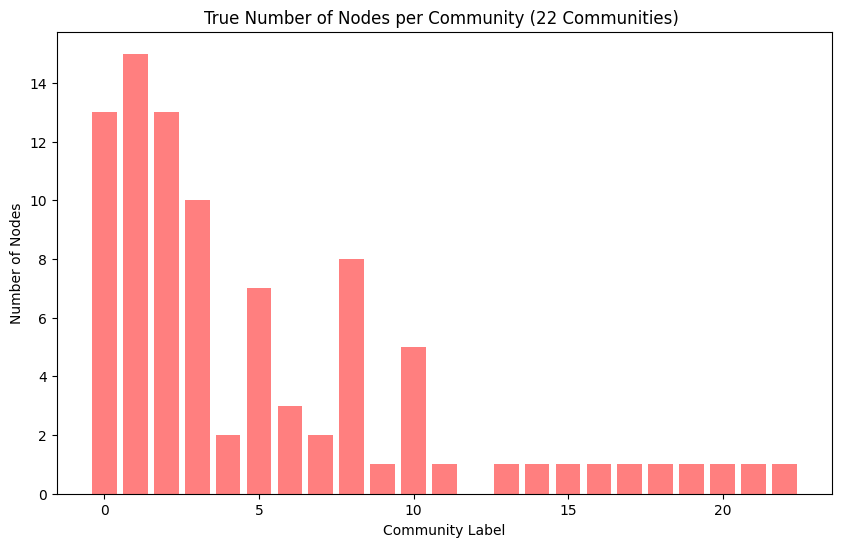

In [ ]:
# Extract community labels and the corresponding number of nodes
true_com = defaultdict(int)
for node, coms in true_labels.items():
        for x in coms:
            true_com[x] += 1
        
true_communities = list(true_com.keys())  # Community labels
true_sizes = list(true_com.values())  # Number of nodes in each community

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(true_communities, true_sizes, color='red', alpha=0.5)

# Add labels and title
plt.xlabel('Community Label')
plt.ylabel('Number of Nodes')
plt.title(f'True Number of Nodes per Community ({len(true_com)} Communities) ')

# Display the plot
plt.show()

### Useful functions

We need `dict_labels` to have the following format:
```
{   
    node1 : [com11, ..., com_1n],
    node2 : [com21, ..., com2m],
    ...
}
```

In [ ]:
def show_boxplot(dict_labels: dict, algo_name: str):
    
    ### Extract community labels and the corresponding number of nodes, for the true labels
    true_com = defaultdict(int)
    for node, coms in true_labels.items():
            for x in coms:
                true_com[x] += 1
            
    true_communities = list(true_com.keys())  # Community labels
    true_sizes = list(true_com.values())  # Number of nodes in each community


    ### Extract community labels and the corresponding number of nodes, for the predicted labels
    count_com = defaultdict(int)
    for node, coms in dict_labels.items():
            for x in coms:
                count_com[x] += 1

    communities = [] # Community labels
    sizes = [] # Number of nodes in each community
    for com in range(max(len(true_com), len(count_com))):
            communities.append(com)
            if com in list(count_com.keys()):
                    sizes.append(count_com[com])
            else:
                    sizes.append(0)

    # Plot the data in louvain
    plt.figure(figsize=(10, 6))
    plt.bar(communities, sizes, alpha=0.5, label=f"{algo_name}")
    plt.bar(true_communities, true_sizes, alpha=0.5, label="True labels")

    # Add labels and title
    plt.xlabel('Community Label')
    plt.ylabel('Number of Nodes')
    plt.title(f'Number of Nodes per Community for {algo_name} ({len(count_com)} Communities)')

    # Display the plot
    plt.legend()
    plt.show()

In [ ]:
def scores(dict_labels: dict, algo_name: str, show=True):
    """
    Compute the accuracy, the omega index, the LFK omni score and the F1-score of dict_labels,
    based on true_labels.
    """

    ########## Accuracy
    s = 0
    for node in G.nodes():
        for x in true_labels[node]:
            if x in dict_labels[node]:
                s += 1 / max(len(true_labels[node]), len(dict_labels[node]))
    accuracy = s/len(G.nodes)

    # Convert to community-to-nodes format
    com_to_nodes = defaultdict(set)
    for node, coms in dict_labels.items():
        for com in coms:
            com_to_nodes[com].add(node)
    pred_communities = list(com_to_nodes.values())


    # Convert to community-to-nodes format
    com_to_nodes = defaultdict(set)
    for node, coms in true_labels.items():
        for com in coms:
            com_to_nodes[com].add(node)
    true_communities = list(com_to_nodes.values())

    # Convert to cdlib format
    true_clusters = NodeClustering(communities=true_communities, graph=G, method_name="ground_truth")
    pred_clusters = NodeClustering(communities=pred_communities, graph=G, method_name="predicted")
    
    ########## Omega Index
    omega = evaluation.omega(true_clusters, pred_clusters)
    ########## Accuracy
    onmi_score = evaluation.overlapping_normalized_mutual_information_LFK(true_clusters, pred_clusters)
    ########## F1-score
    f1_score = evaluation.f1(true_clusters, pred_clusters)

    if show:
        print(f"Accuracy for {algo_name}: {accuracy:.4f}")
        print(f"Omega Index for {algo_name}: {omega.score:.4f}")
        print(f"ONMI for {algo_name}: {onmi_score.score:.4f}")
        print(f"F1-score for {algo_name}: {f1_score.score:.4f}")

    return [accuracy, omega.score, onmi_score.score, f1_score.score]


In [ ]:
def align_labels(dict_labels):
    """
    Use of Hungarian algorithm to find best matching between dict_labels and true_labels community IDs. 
    """

    # number of predicted communities
    n1 = 0
    for node in dict_labels:
        for x in dict_labels[node]:
            if x > n1:
                n1 = x
    # true number of communities
    n2 = 0
    for node in true_labels:
        for x in true_labels[node]:
            if x > n2:
                n2 = x

    # Create confusion matrix
    cm = np.zeros((max(n1,n2) + 1, max(n1,n2) + 1))
    for node in dict_labels:
        for i in true_labels[node]:
            for j in dict_labels[node]:
                cm[i, j] += 1

    # Use Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total score
    
    # Create a mapping from predicted label → true label
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    return mapping

# Louvain

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy. Note that higher resolution $\Longrightarrow$ smaller communities

In [ ]:
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for resolution in tqdm(L_resolution):

    louvain_partition = community_louvain.best_partition(G, resolution=resolution, random_state=42)

    for node in louvain_partition:
        louvain_partition[node] = [louvain_partition[node]]
    # Align labels
    mapping = align_labels(louvain_partition)
    #print("Mapping (pred → true):", mapping)

    # Assign each node the corresponding true label
    louvain_labels = defaultdict(list)
    for node in louvain_partition:
        for x in louvain_partition[node]:
            louvain_labels[node].append(mapping[x])
    
    L_scores = scores(louvain_labels, algo_name="Louvain", show=False)
    if L_scores[0] > best_score:
        best_score = L_scores[0]
        best_resolution = resolution

print(f"Best score = {best_score} and best resolution = {best_resolution}")


100%|██████████| 100/100 [00:07<00:00, 13.04it/s]

Best score = 0.5825136612021857 and best resolution = 0.01


In [ ]:
start = time.time()

# Apply Louvain algorithm
louvain_partition = community_louvain.best_partition(G, resolution=best_resolution, random_state=42)

for node in louvain_partition:
    louvain_partition[node] = [louvain_partition[node]]

# Align labels
mapping = align_labels(louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
louvain_labels = defaultdict(list)
for node in louvain_partition:
    for x in louvain_partition[node]:
        louvain_labels[node].append(mapping[x])

duration = time.time() - start

print(louvain_labels)

defaultdict(<class 'list'>, {881: [5], 858: [5], 828: [2], 697: [2], 884: [1], 864: [1], 856: [3], 869: [2], 889: [3], 872: [8], 873: [8], 719: [2], 713: [2], 861: [3], 863: [3], 840: [2], 803: [0], 745: [2], 805: [2], 865: [10], 857: [10], 874: [8], 708: [2], 823: [2], 885: [8], 870: [5], 871: [5], 888: [3], 825: [1], 774: [2], 729: [3], 769: [15], 800: [2], 819: [16], 859: [17], 876: [3], 887: [8], 895: [5], 890: [2], 810: [2], 879: [20], 753: [3], 830: [2], 747: [2], 776: [8], 772: [2], 804: [7], 886: [6], 893: [1], 811: [19], 867: [8], 868: [10], 878: [3], 877: [8], 882: [3], 894: [20], 866: [20], 880: [21], 703: [21], 798: [15], 862: [10]})


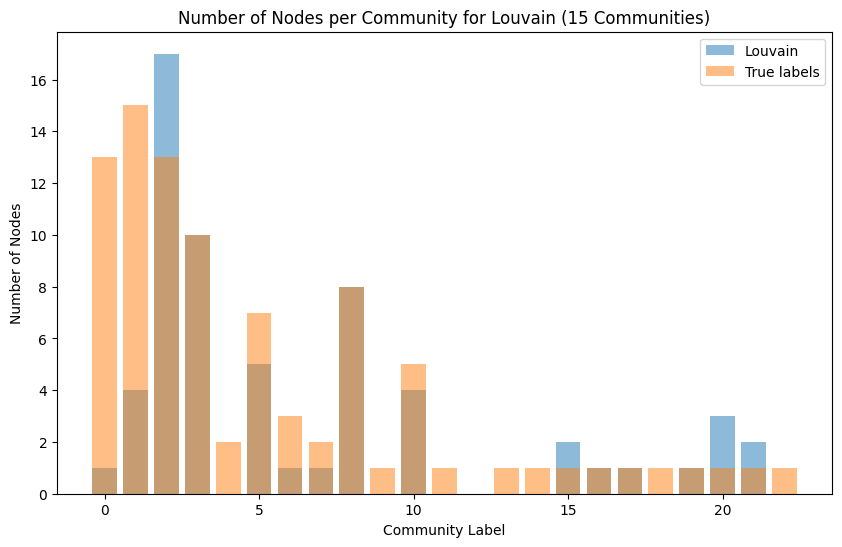

Accuracy for Louvain: 0.5825
Omega Index for Louvain: 0.5004
ONMI for Louvain: 0.4745
F1-score for Louvain: 0.6129
Time for Louvain: 0.0021 s


In [ ]:
algo_name = "Louvain"

show_boxplot(louvain_labels, algo_name)
scores(louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

## Leiden

In [ ]:
# The implemented Leiden needs igraph format
G_ig = ig.Graph.from_networkx(G)

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy.

In [ ]:
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for resolution in tqdm(L_resolution):

    partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition,
                                resolution_parameter=resolution, seed=42)
    # Print community assignments
    leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

    for node in leiden_partition:
        leiden_partition[node] = [leiden_partition[node]]

    # Align labels
    mapping = align_labels(leiden_partition)
    #print("Mapping (pred → true):", mapping)

    # Assign each node the corresponding true label
    leiden_labels = defaultdict(list)
    for node in leiden_partition:
        for x in leiden_partition[node]:
            leiden_labels[node].append(mapping[x])

    
    L_scores = scores(leiden_labels, algo_name="Leiden", show=False)
    if L_scores[0] > best_score:
        best_score = L_scores[0]
        best_resolution = resolution

print(f"Best score = {best_score} and best resolution = {best_resolution}")


100%|██████████| 100/100 [00:07<00:00, 14.20it/s]

Best score = 0.5497267759562842 and best resolution = 1.5415151515151517


In [ ]:
start = time.time()
partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition,
                              resolution_parameter=best_resolution, seed=42)
# Print community assignments
leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

for node in leiden_partition:
    leiden_partition[node] = [leiden_partition[node]]

# Align labels
mapping = align_labels(leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
leiden_labels = defaultdict(list)
for node in leiden_partition:
    for x in leiden_partition[node]:
        leiden_labels[node].append(mapping[x])

duration = time.time() - start

print(leiden_labels)

defaultdict(<class 'list'>, {881: [5], 858: [5], 828: [2], 697: [2], 884: [1], 864: [1], 856: [1], 869: [13], 889: [3], 872: [8], 873: [8], 719: [2], 713: [2], 861: [3], 863: [3], 840: [2], 803: [0], 745: [2], 805: [2], 865: [10], 857: [10], 874: [8], 708: [13], 823: [2], 885: [8], 870: [5], 871: [5], 888: [3], 825: [1], 774: [2], 729: [3], 769: [13], 800: [2], 819: [0], 859: [8], 876: [3], 887: [8], 895: [5], 890: [13], 810: [2], 879: [5], 753: [13], 830: [2], 747: [0], 776: [8], 772: [2], 804: [3], 886: [3], 893: [1], 811: [13], 867: [8], 868: [10], 878: [3], 877: [8], 882: [3], 894: [5], 866: [5], 880: [0], 703: [0], 798: [13], 862: [10]})


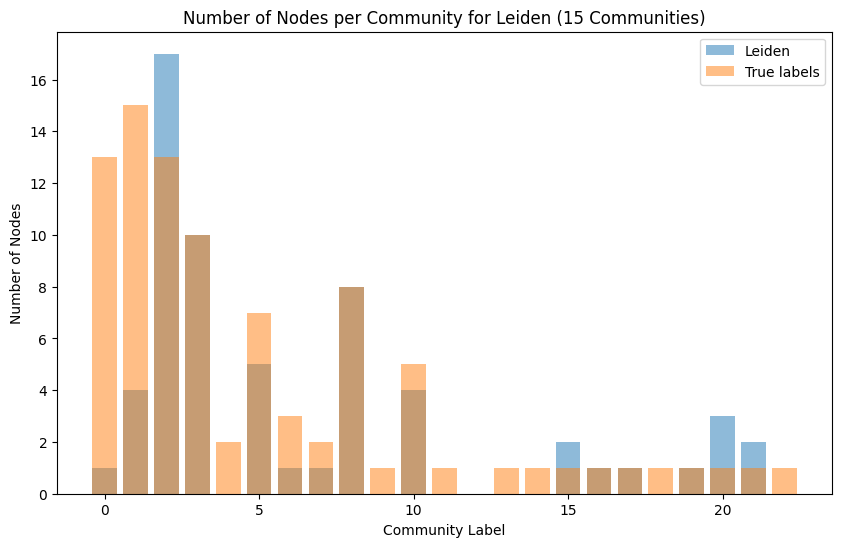

Accuracy for Leiden: 0.5497
Omega Index for Leiden: 0.4642
ONMI for Leiden: 0.3212
F1-score for Leiden: 0.4153
Time for Leiden: 0.0016 s


In [ ]:
algo_name = "Leiden"

show_boxplot(louvain_labels, algo_name)
scores(leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

# Cliqued Louvain

In [ ]:
def find_k_cliques(graph, k):
    """Find all cliques of size exactly k."""
    return [clique for clique in nx.find_cliques(graph) if len(clique) == k]


def reconstruct_graph(graph, k_cliques):
    """
    Replace each k-clique with a supernode and add self-loops.
    Maintain non-classified nodes (NCNs).
    """
    H = nx.Graph()
    node_to_clique = {}
    supernode_id = 0

    # Step 2: Convert each clique to a supernode with self-loop
    for clique in k_cliques:
        supernode = f"C{supernode_id}"
        supernode_id += 1
        H.add_node(supernode)
        num_edges = len(clique) * (len(clique) - 1) // 2
        H.add_edge(supernode, supernode, weight=num_edges)
        for node in clique:
            node_to_clique.setdefault(node, []).append(supernode)

    # Step 3: Add remaining nodes and original edges
    for u, v in graph.edges():
        clique_u = node_to_clique.get(u, None)
        clique_v = node_to_clique.get(v, None)

        if clique_u is None and clique_v is None:
            # Both are NCNs
            H.add_edge(u, v)
        elif clique_u is None:
            # u is NCN, v is in clique(s)
            for v_clique in clique_v:
                H.add_edge(u, v_clique)
        elif clique_v is None:
            # v is NCN, u is in clique(s)
            for u_clique in clique_u:
                H.add_edge(v, u_clique)
        else:
            # Both are part of cliques
            for cu in clique_u:
                for cv in clique_v:
                    if cu != cv:
                        H.add_edge(cu, cv)

    return H

In [ ]:
def apply_louvain(H, resolution=1.0):
    """Apply Louvain and return community partition."""
    partition = community_louvain.best_partition(H, resolution=resolution)
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, []).append(node)
    return list(communities.values())


def clique_based_louvain_cbla(graph, k, resolution=1.0):
    """
    Main function for Clique-Based Louvain Algorithm (CBLA).
    Based on provided algorithm steps.
    """
    k_cliques = find_k_cliques(graph, k)
    reconstructed_graph = reconstruct_graph(graph, k_cliques)

    # Step 4: Apply Louvain until NCNs are assigned
    communities = apply_louvain(reconstructed_graph, resolution)

    # Map back to original nodes
    node_assignments = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            if isinstance(node, str) and node.startswith("C"):
                # Clique supernode: map to original clique nodes
                idx = int(node[1:])
                for original_node in k_cliques[idx]:
                    node_assignments.setdefault(original_node, set()).add(comm_id)
            else:
                # NCN node
                node_assignments.setdefault(node, set()).add(comm_id)

    return node_assignments

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy.

In [ ]:
L_k = [1,2,3,4,5,6,7]
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for k in L_k:
    print(f"k = {k}")
    for resolution in tqdm(L_resolution):

        cb_louvain_partition = clique_based_louvain_cbla(G, k, resolution)
        for node in cb_louvain_partition:
            cb_louvain_partition[node] = list(cb_louvain_partition[node])

        # Align labels
        mapping = align_labels(cb_louvain_partition)
        #print("Mapping (pred → true):", mapping)

        # Assign each node the corresponding true label
        cb_louvain_labels = {node: [mapping[i] for i in cb_louvain_partition[node]] for node in cb_louvain_partition}

        L_scores = scores(cb_louvain_labels, algo_name="CB Louvain", show=False)
        if L_scores[0] > best_score:
            best_score = L_scores[0]
            best_k, best_resolution = k, resolution

    print(f"Best score = {best_score}")
print(f"Best k = {best_k} and best resolution = {best_resolution}")


k = 1


100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


Best score = 0.5743169398907103
k = 2


100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


Best score = 0.5743169398907103
k = 3


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


Best score = 0.5743169398907103
k = 4


100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


Best score = 0.5743169398907103
k = 5


100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


Best score = 0.5912568306010928
k = 6


100%|██████████| 100/100 [00:07<00:00, 14.21it/s]


Best score = 0.5912568306010928
k = 7


100%|██████████| 100/100 [00:09<00:00, 10.68it/s]

Best score = 0.5912568306010928
Best k = 5 and best resolution = 1.3803030303030304


In [ ]:
start = time.time()

cb_louvain_partition = clique_based_louvain_cbla(G, best_k, best_resolution)
for node in cb_louvain_partition:
    cb_louvain_partition[node] = list(cb_louvain_partition[node])

# Align labels
mapping = align_labels(cb_louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
cb_louvain_labels = {node: [mapping[i] for i in cb_louvain_partition[node]] for node in cb_louvain_partition}
duration = time.time() - start

print(cb_louvain_labels)

{856: [1, 3], 772: [1], 800: [1], 697: [1, 2], 828: [1], 884: [1], 864: [1], 825: [1], 893: [1], 729: [3], 753: [3, 2], 889: [3], 861: [3], 878: [3], 804: [3], 888: [3], 863: [3], 876: [3], 882: [3], 886: [3], 858: [5], 881: [5], 871: [5], 870: [5], 895: [5], 879: [5], 866: [5], 894: [5], 890: [2, 13], 769: [2, 13], 708: [2, 13], 811: [13], 869: [13], 798: [13], 810: [0], 819: [0], 880: [0], 703: [0], 830: [0], 823: [0], 745: [0], 840: [0], 774: [0], 747: [0], 713: [0], 719: [0], 805: [0], 803: [0], 872: [8], 873: [8], 885: [8], 887: [8], 867: [8], 776: [8], 874: [8], 859: [8], 877: [8], 865: [10], 857: [10], 868: [10], 862: [10]}


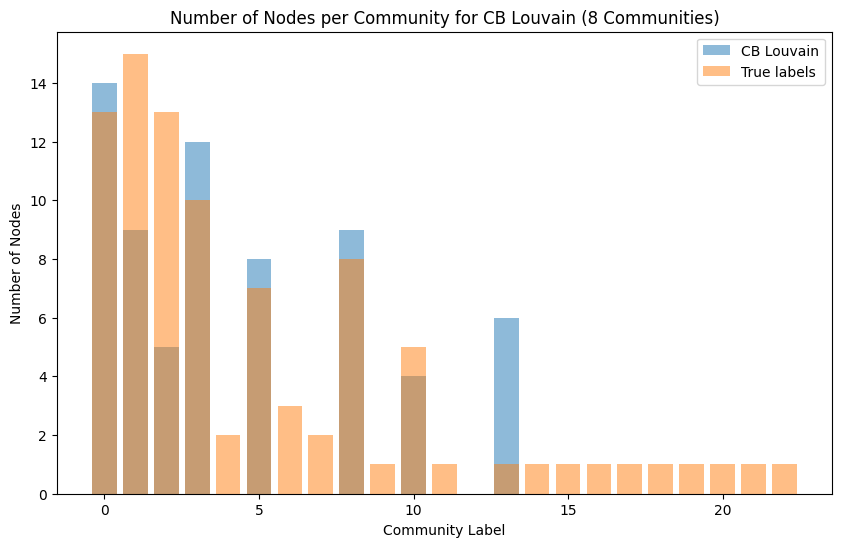

Accuracy for CB Louvain: 0.5448
Omega Index for CB Louvain: 0.4497
ONMI for CB Louvain: 0.2827
F1-score for CB Louvain: 0.3932
Time for CB Louvain: 0.0048 s


In [ ]:
algo_name = "CB Louvain"

show_boxplot(cb_louvain_labels, algo_name)
scores(cb_louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

# Cliqued Leiden

In [ ]:
def apply_leiden(H, resolution=1.0):
    """Apply Louvain and return community partition."""
    H_ig = ig.Graph.from_networkx(H)
    H_ig.vs["name"] = list(H.nodes())
    
    partition = la.find_partition(H_ig, la.RBConfigurationVertexPartition,
                              resolution_parameter=resolution)
    
    communities = {}
    for node_id, comm_id in enumerate(partition.membership):
        communities.setdefault(comm_id, []).append(H_ig.vs["name"][node_id])

    return list(communities.values())


def clique_based_leiden_cbla(G, k, resolution=1.0):
    """
    Main function for Clique-Based Leiden Algorithm
    """
    k_cliques = find_k_cliques(G, k)
    reconstructed_graph = reconstruct_graph(G, k_cliques)

    communities = apply_leiden(reconstructed_graph, resolution)
    # Map back to original nodes
    node_assignments = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            if isinstance(node, str) and node.startswith("C"):
                # Clique supernode: map to original clique nodes
                idx = int(node[1:])
                for original_node in k_cliques[idx]:
                    node_assignments.setdefault(original_node, set()).add(comm_id)
            else:
                # NCN node
                node_assignments.setdefault(node, set()).add(comm_id)

    return node_assignments

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy.

In [ ]:
L_k = [1,2,3,4,5,6,7]
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for k in L_k:
    print(f"k = {k}")
    for resolution in tqdm(L_resolution):

        cb_leiden_partition = clique_based_leiden_cbla(G, k, resolution)
        for node in cb_leiden_partition:
            cb_leiden_partition[node] = list(cb_leiden_partition[node])

        # Align labels
        mapping = align_labels(cb_leiden_partition)
        #print("Mapping (pred → true):", mapping)

        # Assign each node the corresponding true label
        cb_leiden_labels = {node: [mapping[i] for i in cb_leiden_partition[node]] for node in cb_leiden_partition}

        L_scores = scores(cb_leiden_labels, algo_name="CB Leiden", show=False)
        if L_scores[0] > best_score:
            best_score = L_scores[0]
            best_k, best_resolution = k, resolution

    print(f"Best score = {best_score}")
print(f"Best k = {best_k} and best resolution = {best_resolution}")


k = 1


100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


Best score = 0.5497267759562842
k = 2


100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


Best score = 0.5497267759562842
k = 3


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Best score = 0.5617486338797814
k = 4


100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


Best score = 0.5617486338797814
k = 5


100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Best score = 0.5617486338797814
k = 6


100%|██████████| 100/100 [00:06<00:00, 15.31it/s]


Best score = 0.5617486338797814
k = 7


100%|██████████| 100/100 [00:06<00:00, 15.07it/s]

Best score = 0.6060109289617486
Best k = 7 and best resolution = 1.34


In [ ]:
start = time.time()

cb_leiden_partition = clique_based_leiden_cbla(G, best_k, best_resolution)
for node in cb_leiden_partition:
    cb_leiden_partition[node] = list(cb_leiden_partition[node])

# Align labels
mapping = align_labels(cb_leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
cb_leiden_labels = {node: [mapping[i] for i in cb_leiden_partition[node]] for node in cb_leiden_partition}
duration = time.time() - start

print(cb_leiden_labels)

{805: [0], 828: [0, 2], 747: [0, 2, 1], 823: [0, 1], 880: [0], 819: [0, 1], 703: [0], 719: [0], 772: [0], 800: [0, 2], 713: [0], 697: [0, 2, 1], 856: [0, 2, 1, 3], 810: [0], 774: [0, 2], 830: [0], 745: [0], 840: [0], 803: [0], 769: [2], 708: [2, 1], 890: [2], 869: [2], 811: [2], 798: [2], 753: [1], 884: [1], 864: [1], 825: [1], 893: [1], 876: [3], 804: [3], 729: [3], 889: [3], 863: [3], 882: [3], 886: [3], 878: [3], 888: [3], 861: [3], 881: [5], 858: [5], 895: [5], 879: [5], 871: [5], 866: [5], 870: [5], 894: [5], 872: [8], 873: [8], 885: [8], 887: [8], 867: [8], 776: [8], 874: [8], 859: [8], 877: [8], 865: [10], 857: [10], 868: [10], 862: [10]}


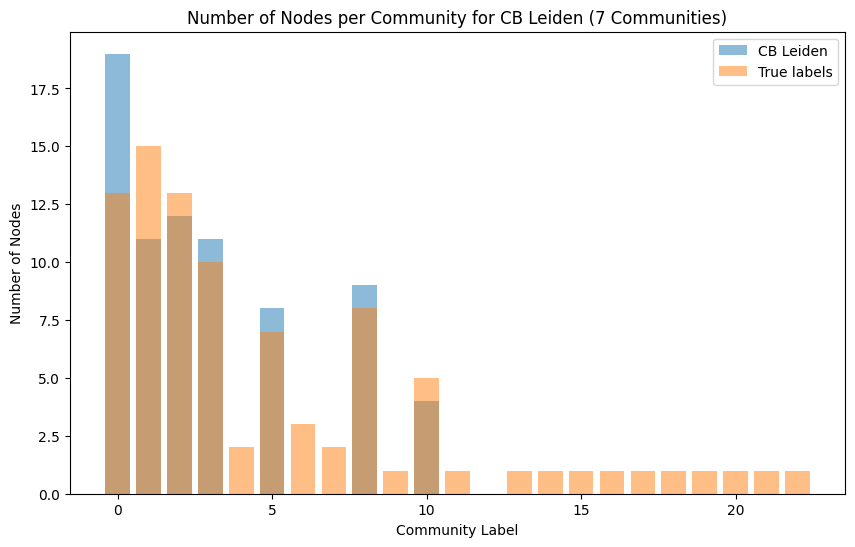

Accuracy for CB Leiden: 0.5842
Omega Index for CB Leiden: 0.4881
ONMI for CB Leiden: 0.3579
F1-score for CB Leiden: 0.3506
Time for CB Leiden: 0.0027 s


In [ ]:
algo_name = "CB Leiden"

show_boxplot(cb_leiden_labels, algo_name)
scores(cb_leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")